# Project: Monitoring NDVI Changes and Segmenting Lost Vegetation

## 1. Introduction
**Objective**: Monitor the changes in NDVI over the years and segment areas of lost vegetation to classify what they have been converted to using the EuroSAT dataset.

**Tools**: Python, Satellite Imagery, NDVI Calculation, EuroSAT Dataset, Machine Learning Models

## 2. Data Collection and Preparation
### Step 1: Collect Satellite Images
- **Sources**: Landsat, Sentinel-2
- **Period**: Define the years for monitoring (e.g., 2000-2020)
- **Regions**: Define the geographic regions of interest

### Step 2: Preprocess Satellite Images
- **Cloud Masking**: Remove clouds and shadows
- **Radiometric Calibration**: Correct sensor noise and inconsistencies

### Step 3: Calculate NDVI
- **Formula**: NDVI = (NIR - RED) / (NIR + RED)
- **Implementation**: Use libraries like `rasterio` and `numpy`

### Step 4: Load EuroSAT Dataset
- **Download**: Obtain the EuroSAT dataset
- **Categories**: Urban, Agriculture, Forest, etc.

## 3. NDVI Analysis
### Step 1: Compute Yearly NDVI Maps
- **Mean NDVI**: Calculate average NDVI for each year
- **Seasonal NDVI**: If needed, calculate for different seasons

Table. Quote: **Holben, B.N. (1986). Characteristics of Maximum- Value Composite Images from Temporal AVHRR Data. International Journal of Remote Sensing, 7(11), 1417-1434.** 
| NDVI Range    | Class                |
|----------------|---------------------|
| <0             | water               |
| 0.03 – 0       | bare soil           |
| 0.03 – 0.3     | sparse vegetation   |
| 0.3 – 0.5      | moderate vegetation |
| >0.5           | dense vegetation    |

### Step 2: Identify Changes in NDVI
- **Trend Analysis**: Use statistical methods to identify significant changes over the years
- **Change Detection**: Highlight areas with significant NDVI reduction

## 4. Segmentation of Lost Vegetation
### Step 1: Identify Lost Vegetation Tiles
- **Thresholding**: Define NDVI thresholds to identify loss
- **Mask Creation**: Create masks for areas of NDVI reduction

### Step 2: Extract Lost Vegetation Tiles
- **Coordinate Extraction**: Get coordinates of identified tiles
- **Tile Extraction**: Extract these regions from satellite images

## 5. Classification Using EuroSAT
### Step 1: Data Preparation
- **Tile Labelling**: Label extracted tiles according to EuroSAT categories
- **Data Augmentation**: If necessary, augment data to improve model performance

### Step 2: Model Selection and Training
- **Model**: Choose a suitable classification model (e.g., CNN)
- **Training**: Train the model using EuroSAT dataset
- **Validation**: Validate model performance on a separate validation set

### Step 3: Classification of Lost Vegetation Tiles
- **Prediction**: Use the trained model to classify lost vegetation tiles
- **Post-processing**: Aggregate and interpret classification results

## 6. Results and Analysis
### Step 1: Visualization
- **NDVI Changes**: Visualize NDVI changes over the years using plots or maps
- **Classified Tiles**: Map out classified lost vegetation tiles

### Step 2: Interpretation
- **Land Use Changes**: Interpret what the lost vegetation has been converted to
- **Environmental Impact**: Discuss potential environmental impacts

## 7. Conclusion
- **Summary**: Summarize key findings
- **Future Work**: Suggest possible extensions or improvements

## 8. References and Documentation
- **References**: List of scholarly articles, datasets, and tools used
- **Documentation**: Detailed code comments and project documentation


In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds
import IPython.display as disp
from tqdm.auto import tqdm
import pandas as pd
import os

import geemap
import rasterio
import requests
import matplotlib.pyplot as plt
import cv2

2024-06-25 01:58:30.611419: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-25 01:58:31.362419: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Initialize Earth Engine API

In [2]:
import ee
ee.Authenticate()
ee.Initialize(project='cementification')

In [3]:
imageCollectionInfoUrl = 'https://storage.googleapis.com/earthengine-stac/catalog/LANDSAT/LANDSAT_LE07_C02_T1_L2.json'
r = requests.get(imageCollectionInfoUrl)
imageCollInfo = r.json()
print(imageCollInfo)

{'description': 'This dataset contains atmospherically corrected\nsurface reflectance and land surface temperature derived from the data\nproduced by the Landsat 7 ETM+ sensor.\nThese images contain 4 visible and near-infrared (VNIR) bands and\n2 short-wave infrared (SWIR) bands processed to orthorectified surface\nreflectance, and one thermal infrared (TIR) band processed to orthorectified\nsurface temperature. They also contain intermediate bands used in\ncalculation of the ST products, as well as QA bands.\n\nLandsat 7 SR products are created with the Landsat Ecosystem Disturbance\nAdaptive Processing System (LEDAPS) algorithm (version 3.4.0).\nAll Collection 2 ST products are created with a single-channel algorithm\njointly created by the Rochester Institute of Technology (RIT) and\nNational Aeronautics and Space Administration (NASA)\nJet Propulsion Laboratory (JPL).\n\nStrips of collected data are packaged into overlapping \\"scenes\\" covering approximately\n170km x 183km using 

In [4]:
bands = []

for key, value in imageCollInfo.items():
    if key == 'summaries':
        for key2, value2 in value.items():
            if key2 == 'eo:bands':
                for band in value2:
                    print(f'{band["name"]}: {band}')
                    bands.append(band['name'])

SR_B1: {'center_wavelength': 0.485, 'description': 'Band 1 (blue) surface reflectance', 'gee:offset': -0.2, 'gee:scale': 2.75e-05, 'gee:wavelength': '0.45-0.52 &mu;m', 'name': 'SR_B1'}
SR_B2: {'center_wavelength': 0.56, 'description': 'Band 2 (green) surface reflectance', 'gee:offset': -0.2, 'gee:scale': 2.75e-05, 'gee:wavelength': '0.52-0.60 &mu;m', 'name': 'SR_B2'}
SR_B3: {'center_wavelength': 0.66, 'description': 'Band 3 (red) surface reflectance', 'gee:offset': -0.2, 'gee:scale': 2.75e-05, 'gee:wavelength': '0.63-0.69 &mu;m', 'name': 'SR_B3'}
SR_B4: {'center_wavelength': 0.835, 'description': 'Band 4 (near infrared) surface reflectance', 'gee:offset': -0.2, 'gee:scale': 2.75e-05, 'gee:wavelength': '0.77-0.90 &mu;m', 'name': 'SR_B4'}
SR_B5: {'center_wavelength': 1.65, 'description': 'Band 5 (shortwave infrared 1) surface reflectance', 'gee:offset': -0.2, 'gee:scale': 2.75e-05, 'gee:wavelength': '1.55-1.75 &mu;m', 'name': 'SR_B5'}
SR_B7: {'center_wavelength': 2.215, 'description': 'B

In [5]:
city = 'naples'

if city == 'milan':
    geometry = ee.Geometry.Polygon(
        [[[8.967864766059032, 45.73943107755818],
          [8.967864766059032, 45.41260677458684],
          [9.434783711371532, 45.41260677458684],
          [9.434783711371532, 45.73943107755818]]])
elif city == 'naples':
    geometry = ee.Geometry.Polygon(
        [[[13.829280147955982, 41.1031243453332],
          [13.829280147955982, 40.51481111232291],
          [14.587336788580982, 40.51481111232291],
          [14.587336788580982, 41.1031243453332]]])

# Using Landsat 7 images (from 1999 to 2022, 30m resolution)

In [6]:
# Function to compute NDVI
def compute_ndvi(image):
    ndvi = image.normalizedDifference(['SR_B4', 'SR_B3']).rename('NDVI').multiply(10000).toInt16()
    return image.addBands(ndvi)

# Function to filter the collection by season and compute median NDVI
def median_ndvi_for_year(year):
    start_date = ee.Date.fromYMD(year, 3, 1)
    end_date = start_date.advance(6, 'month')
    year_collection = ee.ImageCollection("LANDSAT/LE07/C02/T1_L2") \
                .filterBounds(geometry) \
                .filterDate(start_date, end_date) \
                .filter(ee.Filter.lt('CLOUD_COVER', 20)) \
                .select(['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4']) \
                .map(compute_ndvi) \
                .select(['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'NDVI'])

    return year_collection.median().clip(geometry).set('year', year)

# Generate a list of years
years = ee.List.sequence(1999, 2023)

year_ndvi = years.map(median_ndvi_for_year).flatten()

# Convert the list of images to an image collection
years_ndvi_collection = ee.ImageCollection(year_ndvi)

# Print the size of the seasonal NDVI collection
print(f'Adding {years_ndvi_collection.size().getInfo()} annual layers')

# Define visualization parameters for NDVI
vis_param_ndvi = {
    'min': -1, 
    'max': 1, 
    'bands': ['NDVI'],
    'palette': ['blue', 'white', 'green']}

# Create a progress bar
total_iterations = len(years.getInfo())
progress_bar = tqdm(total=total_iterations)

# Export each annual median NDVI
export = False
for year in range(1999, 2024): # From 1999 to 2023
    year_ndvi = years_ndvi_collection.filter(ee.Filter.eq('year', year)).first()
    
    # Ensure consistent band data types
    # year_ndvi = year_ndvi.toInt16()

    # print(f'info about year_ndvi: {year_ndvi.getInfo()} bands {year_ndvi.bandNames().getInfo()}')
    
    if export:
        # Export the image to Google Drive
        task = ee.batch.Export.image.toDrive(
            image=year_ndvi,
            description=f"{city}_{year}",
            folder="Environment_exam_annual_20_cloud_no_int16",
            fileNamePrefix=f"{city}_{year}",
            scale=30,
            region=geometry.getInfo()['coordinates'],
            fileFormat='GeoTIFF',
            skipEmptyTiles=True
        )
        task.start()
    
    progress_bar.update()  # Update the progress bar

# Close the progress bar
progress_bar.close()

Adding 25 annual layers


  0%|          | 0/25 [00:00<?, ?it/s]

# Segment using NDVI

In [38]:
# Initialize an empty list to store the data
data = []

landsat_path = 'images/landsat_8'
for img in os.listdir(landsat_path):
    city, year = img.split('_')
    # Append a dictionary with the data to the list
    data.append({'city': city, 'year': year, 'path': f'{landsat_path}/{img}'})

# Create a DataFrame from the list
img_df = pd.DataFrame(data, columns=['city', 'year', 'path', 'water', 'roads_or_urban_areas', 'vegetation'])
img_df.sort_values(by=['city', 'year'], inplace=True)
img_df.reset_index(drop=True, inplace=True)
img_df

,city,year,path,water,roads_or_urban_areas,vegetation
0,milan,2013.tif,images/landsat_8/milan_2013.tif,NaN,NaN,NaN
1,milan,2014.tif,images/landsat_8/milan_2014.tif,NaN,NaN,NaN
2,milan,2015.tif,images/landsat_8/milan_2015.tif,NaN,NaN,NaN
3,milan,2016.tif,images/landsat_8/milan_2016.tif,NaN,NaN,NaN
4,milan,2017.tif,images/landsat_8/milan_2017.tif,NaN,NaN,NaN
5,milan,2018.tif,images/landsat_8/milan_2018.tif,NaN,NaN,NaN
6,milan,2019.tif,images/landsat_8/milan_2019.tif,NaN,NaN,NaN
7,milan,2020.tif,images/landsat_8/milan_2020.tif,NaN,NaN,NaN
8,milan,2021.tif,images/landsat_8/milan_2021.tif,NaN,NaN,NaN
9,milan,2022.tif,images/landsat_8/milan_2022.tif,NaN,NaN,NaN


In [ ]:
for img in img_df['path']:
    with rasterio.open(img) as src:
        print(f'Bands {src.descriptions}')
        blue_band = src.read(2)
        green_band = src.read(3)
        red_band = src.read(4)
        ndvi = src.read(6)
        plt.imshow(ndvi, cmap='RdYlGn')
        plt.colorbar()
        plt.title(img)
        plt.show()

In [40]:
# Define the NDVI thresholds
ndvi_thresholds = {
    'water': (-10000, 0),
    'roads_or_urban_areas': (0, 2000),
    'vegetation': (2000, 10000)
}

# Define a function to classify NDVI values
def compute_percentages_by_threshold(ndvi_img, thresholds):
    # Initialize an empty dictionary to store the percentages
    percentages = {}

    # ndvi_img is a numpy.ndarray and thresholds is a dictionary
    # with keys as labels and values as a tuple of (lower_bound, upper_bound)
    percentages = {}
    for key, value in thresholds.items():
        # Create a boolean mask where values within the threshold are True
        mask = (ndvi_img > value[0]) & (ndvi_img <= value[1])
        # Compute the percentage of True values in the mask
        percentage = np.mean(mask) * 100  # Convert fraction to percentage
        percentages[key] = percentage
    
    return percentages

In [42]:
# TODO NORMALIZE THE NDVI VALUES

for img in img_df['path']:
    with rasterio.open(img) as src:
        print(f'Image: {img}')
        ndvi = src.read(6)
        percentages = compute_percentages_by_threshold(ndvi, ndvi_thresholds)
        img_df.loc[img_df['path'] == img, ['water', 'roads_or_urban_areas', 'vegetation']] = percentages.values()

img_df

Image: images/landsat_8/milan_2013.tif
{'water': 0.05548493261050908, 'roads_or_urban_areas': 36.47949052670783, 'vegetation': 63.46502454068167}
Image: images/landsat_8/milan_2014.tif
{'water': 0.04113865722662745, 'roads_or_urban_areas': 39.77044059216864, 'vegetation': 60.188420750604735}
Image: images/landsat_8/milan_2015.tif
{'water': 0.02693489451212213, 'roads_or_urban_areas': 35.43682033332763, 'vegetation': 64.53624477216025}
Image: images/landsat_8/milan_2016.tif
{'water': 0.15434122093454108, 'roads_or_urban_areas': 35.33017335241103, 'vegetation': 64.51548542665442}
Image: images/landsat_8/milan_2017.tif
{'water': 0.09999638967904247, 'roads_or_urban_areas': 40.63164465320967, 'vegetation': 59.26835895711129}
Image: images/landsat_8/milan_2018.tif
{'water': 0.047171693563557805, 'roads_or_urban_areas': 37.46401555098248, 'vegetation': 62.48881275545396}
Image: images/landsat_8/milan_2019.tif
{'water': 0.04389390216790273, 'roads_or_urban_areas': 42.70164117590054, 'vegetati

,city,year,path,water,roads_or_urban_areas,vegetation
0,milan,2013.tif,images/landsat_8/milan_2013.tif,0.055485,36.479491,63.465025
1,milan,2014.tif,images/landsat_8/milan_2014.tif,0.041139,39.770441,60.188421
2,milan,2015.tif,images/landsat_8/milan_2015.tif,0.026935,35.436820,64.536245
3,milan,2016.tif,images/landsat_8/milan_2016.tif,0.154341,35.330173,64.515485
4,milan,2017.tif,images/landsat_8/milan_2017.tif,0.099996,40.631645,59.268359
5,milan,2018.tif,images/landsat_8/milan_2018.tif,0.047172,37.464016,62.488813
6,milan,2019.tif,images/landsat_8/milan_2019.tif,0.043894,42.701641,57.254465
7,milan,2020.tif,images/landsat_8/milan_2020.tif,0.063466,33.616744,66.319791
8,milan,2021.tif,images/landsat_8/milan_2021.tif,0.052445,44.935432,55.012123
9,milan,2022.tif,images/landsat_8/milan_2022.tif,0.067789,50.489911,49.442300


In [9]:
import numpy as np
import cv2
import rasterio
import matplotlib.pyplot as plt

def fill_gaps(image, mask_img, kernel_size=3):
    # Replace NaN and infinite values with zero
    image = np.nan_to_num(image, nan=0, posinf=0, neginf=0)
    mask_img = np.nan_to_num(mask_img, nan=0, posinf=0, neginf=0)

    # Normalize the image to 0-255 for inpainting
    if image.dtype != np.uint8:
        norm_image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
        image_uint8 = norm_image.astype(np.uint8)
    else:
        image_uint8 = image

    mask = (mask_img == 0).astype(np.uint8)

    if mask.sum() == 0:
        print('Warning: No gaps detected in the mask image. Returning original image.')
        return image_uint8

    filled_image = cv2.inpaint(image_uint8, mask, kernel_size, cv2.INPAINT_TELEA)

    # Denormalize the filled image
    filled_image = filled_image.astype(float) * (image.max() - image.min()) / 255 + image.min()

    return filled_image

images/landsat/20_clouds_no_int16/milan_2009.tif
Bands: ('SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'NDVI')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.6022125].


(array([False,  True]), array([2104532,     544]))


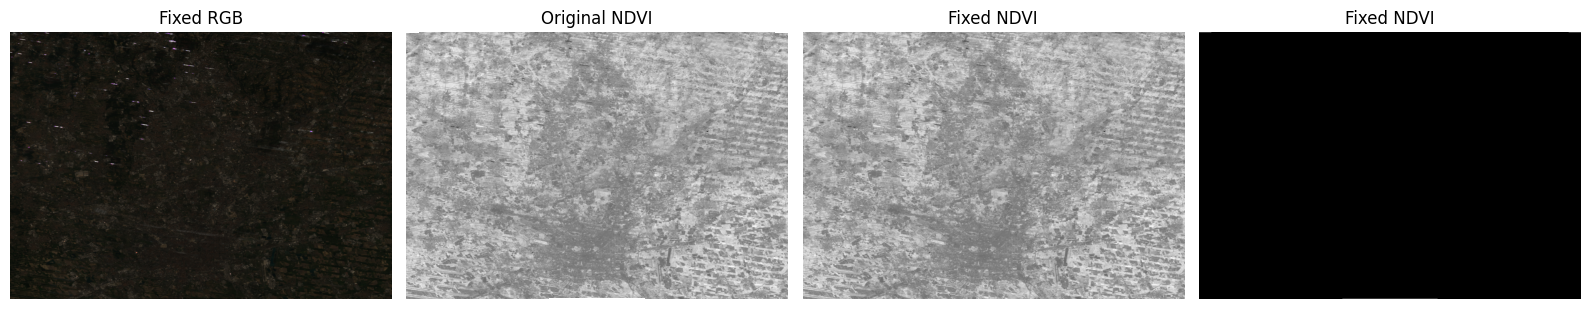

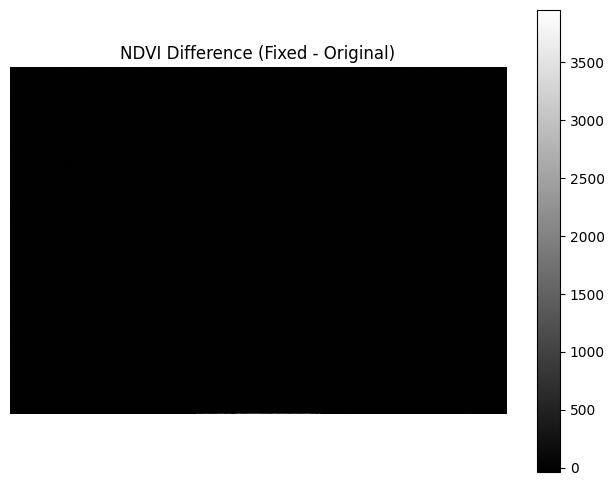

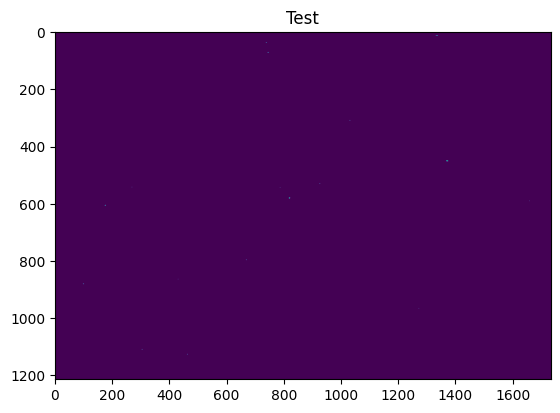

In [12]:
img_2013 = img_df['path'][10]
print(img_2013)

with rasterio.open(img_2013) as src:
    print(f'Bands: {src.descriptions}')

    # Read and normalize the bands for display
    red_band = src.read(3) * 2.75e-05 - 0.2
    green_band = src.read(2) * 2.75e-05 - 0.2
    blue_band = src.read(1) * 2.75e-05 - 0.2

    red_band = np.nan_to_num(red_band, nan=0, posinf=0, neginf=0)
    green_band = np.nan_to_num(green_band, nan=0, posinf=0, neginf=0)
    blue_band = np.nan_to_num(blue_band, nan=0, posinf=0, neginf=0)
    
    # Stack and clip for RGB display
    rgb_image = np.stack((red_band, green_band, blue_band), axis=-1)
    
    ndvi = src.read(5)
    
    # Fix NDVI with the red band as the mask
    fixed_ndvi = fill_gaps(ndvi, red_band, kernel_size=21)
    
# Plot the fixed RGB image
plt.figure(figsize=(16, 4))
plt.subplot(141)
plt.imshow(rgb_image)
plt.title('Fixed RGB')
plt.axis('off')

# Plot the original NDVI image
plt.subplot(142)
plt.imshow(ndvi, cmap='gray')
plt.title('Original NDVI')
plt.axis('off')

# Plot the fixed NDVI image
plt.subplot(143)
plt.imshow(fixed_ndvi, cmap='gray')
plt.title('Fixed NDVI')
plt.axis('off')

# Plot the fixed NDVI image
mask = np.isnan(red_band).astype(np.uint8)
mask = np.nan_to_num(red_band, nan=0, posinf=0, neginf=0)
mask = mask == 0
print(np.unique(mask, return_counts=True))
plt.subplot(144)
plt.imshow(mask, cmap='gray')
plt.title('Fixed NDVI')
plt.axis('off')

plt.tight_layout()
plt.show()

# Calculate and plot the difference
ndvi_diff = fixed_ndvi - np.nan_to_num(ndvi, nan=0, posinf=0, neginf=0)

plt.figure(figsize=(8, 6))
plt.imshow(ndvi_diff, cmap='gray')
plt.title('NDVI Difference (Fixed - Original)')
plt.colorbar()
plt.axis('off')
plt.show()

max red_band 1.6022125


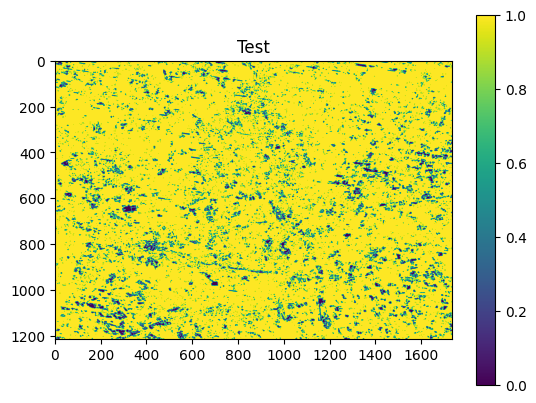

In [23]:
print(f'max red_band {red_band.max()}')
plt.imshow(red_band < red_band.max()*0.1)
plt.title('Test')
plt.colorbar()
plt.show()

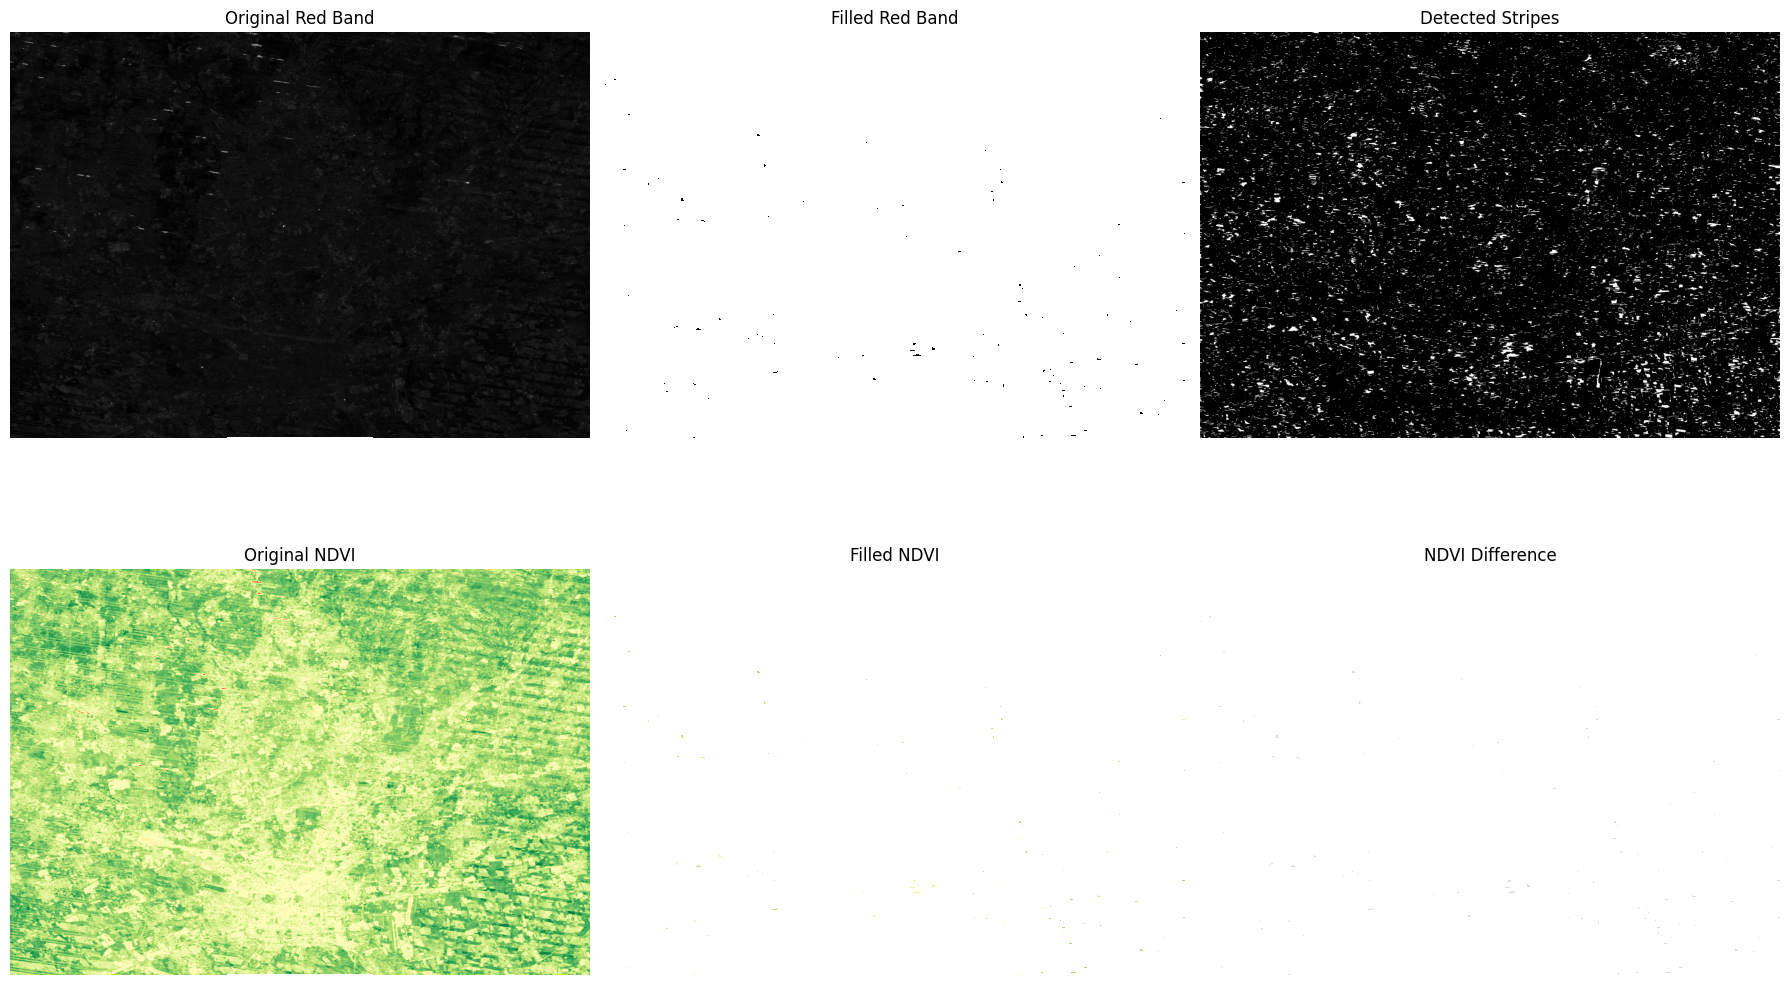

NDVI difference statistics (Filled - Original):
Min: nan, Max: nan, Mean: nan, Std: nan


In [26]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from scipy.ndimage import label, find_objects, binary_dilation
import cv2

def detect_stripes(image, low_threshold=10, high_threshold=50, stripe_width=5):
    """
    Detect stripes in the image using Canny edge detection and morphological operations.
    
    Parameters:
    - image: 2D numpy array of the image band
    - low_threshold: lower threshold for the hysteresis procedure in Canny
    - high_threshold: higher threshold for the hysteresis procedure in Canny
    - stripe_width: expected width of the stripes
    
    Returns:
    - mask: 2D numpy array where 1 indicates detected stripes
    """
    # Normalize image to 0-255 range
    normalized = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    # Apply Canny edge detection
    edges = cv2.Canny(normalized, low_threshold, high_threshold)
    
    # Create a horizontal kernel
    kernel = np.ones((1, stripe_width), np.uint8)
    
    # Apply morphological closing to connect nearby horizontal edges
    closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
    
    # Dilate the result to thicken the stripes
    mask = cv2.dilate(closed, kernel, iterations=2)
    
    return mask

def gapfill(image, mask, max_search=100, step_size=10, kernel_size=5):
    """
    Implement the Gapfill algorithm for Landsat 7 SLC-off images.
    
    Parameters:
    - image: 2D numpy array of the image band
    - mask: 2D numpy array where 1 indicates gaps to be filled
    - max_search: maximum search distance in pixels
    - step_size: step size for increasing search distance
    - kernel_size: size of the kernel for dilation
    
    Returns:
    - filled_image: 2D numpy array of the filled image
    """
    filled_image = np.copy(image)
    
    # Label the connected components in the mask
    labeled_mask, num_features = label(mask)
    
    # Create a circular kernel for dilation
    y, x = np.ogrid[-kernel_size//2:kernel_size//2+1, -kernel_size//2:kernel_size//2+1]
    kernel = x*x + y*y <= (kernel_size//2)**2
    
    for i in range(1, num_features+1):
        # Get the bounding box of each gap
        gap = find_objects(labeled_mask == i)[0]
        gap_mask = labeled_mask[gap] == i
        
        for search_distance in range(step_size, max_search+1, step_size):
            # Dilate the gap mask
            dilated_mask = binary_dilation(gap_mask, structure=kernel, iterations=search_distance//kernel_size)
            
            # Find valid pixels in the search area
            valid_pixels = image[gap][dilated_mask & ~gap_mask]
            
            if len(valid_pixels) > 0:
                # Fill the gap with the median of valid pixels
                filled_image[gap][gap_mask] = np.median(valid_pixels)
                break
    
    return filled_image

# Open the image
with rasterio.open(img_2013) as src:
    red_band = src.read(3)
    nir_band = src.read(4)
    
    # Detect stripes
    red_mask = detect_stripes(red_band)
    nir_mask = detect_stripes(nir_band)
    
    # Combine masks
    combined_mask = np.logical_or(red_mask, nir_mask).astype(np.uint8)
    
    # Apply Gapfill algorithm
    filled_red = gapfill(red_band, combined_mask)
    filled_nir = gapfill(nir_band, combined_mask)
    
    # Calculate NDVI
    ndvi_original = (nir_band - red_band) / (nir_band + red_band + 1e-8)
    ndvi_filled = (filled_nir - filled_red) / (filled_nir + filled_red + 1e-8)

# Plot results
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

axs[0, 0].imshow(red_band, cmap='gray')
axs[0, 0].set_title('Original Red Band')

axs[0, 1].imshow(filled_red, cmap='gray')
axs[0, 1].set_title('Filled Red Band')

axs[0, 2].imshow(combined_mask, cmap='binary')
axs[0, 2].set_title('Detected Stripes')

axs[1, 0].imshow(ndvi_original, cmap='RdYlGn')
axs[1, 0].set_title('Original NDVI')

axs[1, 1].imshow(ndvi_filled, cmap='RdYlGn', vmin=-1, vmax=1)
axs[1, 1].set_title('Filled NDVI')

axs[1, 2].imshow(ndvi_filled - ndvi_original, cmap='coolwarm', vmin=-0.5, vmax=0.5)
axs[1, 2].set_title('NDVI Difference')

for ax in axs.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()

# Print statistics
print("NDVI difference statistics (Filled - Original):")
diff = ndvi_filled - ndvi_original
print(f"Min: {diff.min():.4f}, Max: {diff.max():.4f}, Mean: {diff.mean():.4f}, Std: {diff.std():.4f}")

In [ ]:
sorted_df = img_df.sort_values(by=['city', 'year', 'season'], inplace=False)
sorted_df

In [ ]:
run scripts/dispms -f images/naples_2017_spring.tif -e 5 -p [3,2,1] -d [0,0,5199,3642]

In [ ]:
run scripts/dispms -f images/naples_2017_summer.tif -e 4 -p [2,4,3] -d [0,0,5199,3642]